This notebook shows new functionality of `nideconv` where you can subtract the event-related time courses two conditions from each other and get a corresponding t-value for every timepoint

In [1]:
import nideconv
from nideconv import simulate
import matplotlib.pyplot as plt

Here we simulate some data that resembles the design of Failing et al. (2021)

In [2]:
conditions = [{'name':'plus_type1_exemplar1',
  'mu_group':1,
  'std_group':0.1},
  {'name':'plus_type1_exemplar2',
  'mu_group':1.1,
  'std_group':0.1},
  {'name':'plus_type2_exemplar1',
  'mu_group':1.2,
  'std_group':0.1},
  {'name':'plus_type2_exemplar2',
  'mu_group':1.3,
  'std_group':0.1},
  {'name':'drop_type1_exemplar1',
  'mu_group':.5,
  'std_group':0.1},
  {'name':'drop_type1_exemplar2',
  'mu_group':.5,
  'std_group':0.1},
  {'name':'drop_type2_exemplar1',
  'mu_group':.5,
  'std_group':0.1},
  {'name':'drop_type2_exemplar2',
  'mu_group':.5,
  'std_group':0.1}]

In [3]:
data, onsets, parameters = simulate.simulate_fmri_experiment(conditions, n_rois=2, run_duration=300*7, noise_level=.1)
data.columns = ['voxel 1', 'voxel 2']

Now, we use `ResponseFitter` to fit a Fourier basis set to all 8 conditions

In [4]:
fitter = nideconv.ResponseFitter(data, 1.0, )

for condition in conditions:
    fitter.add_event(condition['name'], onsets.loc[condition['name'], 'onset'],
                    interval=[0, 20], basis_set='fourier', n_regressors=6)
    
fitter.fit()

/Users/gdehol/git/nideconv/nideconv/regressors.py:298: UserWarning: Number of fourier regressors has to be uneven and has automatically been set to 7 per covariate
  warnings.warn('Number of {} regressors has to be uneven and has automatically '


### Subtraction approach

The simplest thing we can do is just subtract the timecourses of the two conditions...

First get a DataFrame with all the timecourses...


In [5]:
tc = fitter.get_timecourses(oversample=5)
tc.head()

voxel 1   voxel 2
event type           covariate time                    
plus_type1_exemplar1 intercept 0.0  -0.040207 -0.049471
                               0.2  -0.040308 -0.047315
                               0.4  -0.036990 -0.041512
                               0.6  -0.029601 -0.031471
                               0.8  -0.017565 -0.016680

... and then subtract the two conditions from each other. We see that the result has changed...

In [6]:
tc_plus_type1_exemplar1_corrected = tc.loc['plus_type1_exemplar1'] - tc.loc['drop_type1_exemplar1'] 

Indeed, we see that the resulting HRF is lower, because the "visual stimulation"-part of the activation is removed.

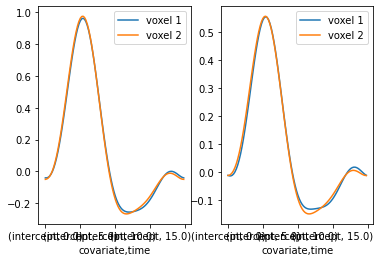

In [7]:
col1 = plt.subplot(121)
tc.loc['plus_type1_exemplar1'].plot(ax=col1)

col2 = plt.subplot(122)
tc_plus_type1_exemplar1_corrected.plot(ax=col2)

plt.gcf().set_size_inches(6, 4)

This function implements a simple t-test, where the timecourse of `condition2` is subtracted from timecourse of `condition1`. Crucially, the variance and covariance of the two estimates is taken into account, using:

$$\text{SEM} = \sqrt{c (X^TX)^{-1}\sigma^2}$$

In [8]:
t = fitter.t_test('plus_type1_exemplar1', 'drop_type1_exemplar1')

/Users/gdehol/git/nideconv/nideconv/response_fitter.py:238: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (c.values.dot(X_) * c).sum(1).values[:, np.newaxis] * self.sigma2[np.newaxis, :])


In [9]:
t

voxel 1   voxel 2
covariate time                     
intercept 0.00  -0.638410 -0.677164
          0.05  -0.672128 -0.670320
          0.10  -0.701105 -0.657937
          0.15  -0.724976 -0.639698
          0.20  -0.743375 -0.615288
...                   ...       ...
          19.75 -0.463380 -0.655403
          19.80 -0.512444 -0.667590
          19.85 -0.558209 -0.675486
          19.90 -0.600317 -0.678781
          19.95 -0.638410 -0.677164

[400 rows x 2 columns]

For this very high quality data, the resulting t-values are very high (30).

<AxesSubplot:xlabel='covariate,time'>

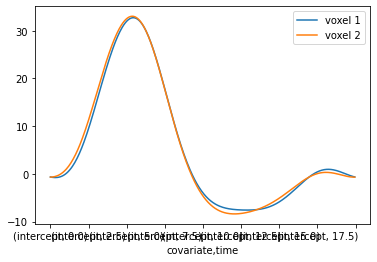

In [10]:
t.plot()

If we simulate noisier data with the same underlying parameters...

/Users/gdehol/git/nideconv/nideconv/regressors.py:298: UserWarning: Number of fourier regressors has to be uneven and has automatically been set to 7 per covariate
  warnings.warn('Number of {} regressors has to be uneven and has automatically '


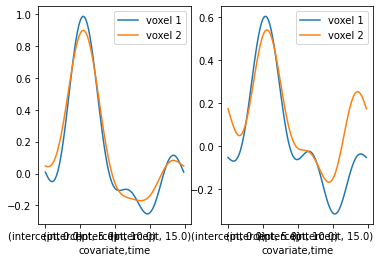

In [11]:
data, onsets, parameters = simulate.simulate_fmri_experiment(conditions, n_rois=2, run_duration=300*7, noise_level=.65)
data.columns = ['voxel 1', 'voxel 2']

fitter = nideconv.ResponseFitter(data, 1.0, )
for condition in conditions:
    fitter.add_event(condition['name'], onsets.loc[condition['name'], 'onset'],
                    interval=[0, 20], basis_set='fourier', n_regressors=6)
    
fitter.fit()

tc = fitter.get_timecourses(oversample=5)

tc_plus_type1_exemplar1_corrected = tc.loc['plus_type1_exemplar1'] - tc.loc['drop_type1_exemplar1'] 

col1 = plt.subplot(121)
tc.loc['plus_type1_exemplar1'].plot(ax=col1)

col2 = plt.subplot(122)
tc_plus_type1_exemplar1_corrected.plot(ax=col2)

plt.gcf().set_size_inches(6, 4)

the differenc eof the percent signal change stays similar (1. vs .6; although the curves become noisier), but the t-values are much lower. This is because the increased standard errors.

/Users/gdehol/git/nideconv/nideconv/response_fitter.py:238: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (c.values.dot(X_) * c).sum(1).values[:, np.newaxis] * self.sigma2[np.newaxis, :])


<AxesSubplot:xlabel='covariate,time'>

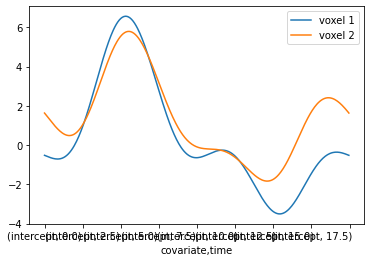

In [12]:
t = fitter.t_test('plus_type1_exemplar1', 'drop_type1_exemplar1')
t.plot()

# Multiple subjects:

In [13]:
data, onsets, parameters = simulate.simulate_fmri_experiment(conditions, 
                                                             n_rois=2, 
                                                             run_duration=300*7, 
                                                             noise_level=.1,
                                                             n_subjects=5,
                                                             n_runs=3)
data.columns = ['voxel 1', 'voxel 2']

In [14]:
group_fitter = nideconv.GroupResponseFitter(data, onsets, 1., concatenate_runs=False)
group_fitter.add_event(basis_set='fourier', n_regressors=7, interval=[0, 20])
group_fitter.fit()

/Users/gdehol/miniconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2877: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(


In [17]:
t = group_fitter.t_test('plus_type1_exemplar1', 'drop_type1_exemplar1', oversample=3)

/Users/gdehol/git/nideconv/nideconv/response_fitter.py:238: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  (c.values.dot(X_) * c).sum(1).values[:, np.newaxis] * self.sigma2[np.newaxis, :])


/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='time', ylabel='voxel 1'>

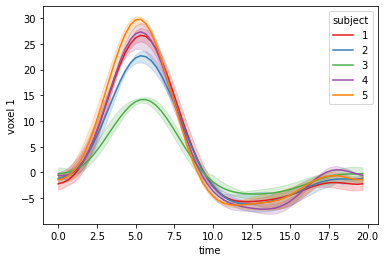

In [22]:
import seaborn as sns
sns.lineplot('time', 'voxel 1', 'subject', data=t, palette='Set1')